In [1]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from utilsforecast.plotting import plot_series
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
#--NotebookApp.iopub_msg_rate_limit=10000

In [40]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
# Y_df = Y_df.query("unique_id in['H1','H2','H3','H4']")
Y_df.head()


,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


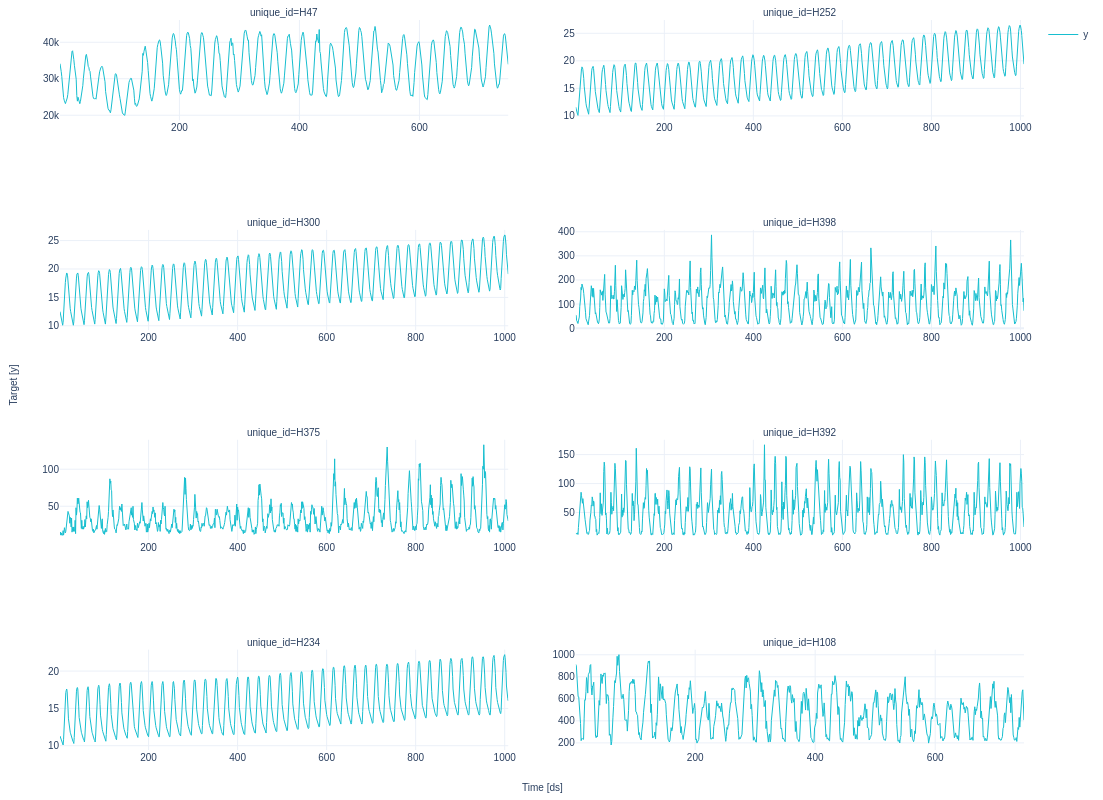

In [41]:
plot_series(Y_df,engine='plotly')

In [42]:
from statsforecast import StatsForecast
from tqdm.autonotebook import tqdm

In [ ]:
#### Baseline Models - Classical models for establishing baseline.
HistoricAverage - 
Naive
RandomWalkWithDrift
SeasonalNaive
WindowAverage
SeasonalWindowAverage

#### Exponential Smoothing
SimpleExponentialSmoothing
SimpleExponentialSmoothingOptimized	
SeasonalExponentialSmoothing
SeasonalExponentialSmoothingOptimized
Holt
HoltWinters
AutoETS
AutoCES

#### ARIMA Family
AutoARIMA
AutoRegressive	

#### Theta Family
Theta
OptimizedTheta
DynamicTheta
DynamicOptimizedTheta
AutoTheta

#### Multiple Seasonalities
MSTL
AutoMFLES	
AutoTBATS
#### GARCH and ARCH Models
GARCH	
ARCH


#### Sparse or Inttermitent 
ADIDA
CrostonClassic	
CrostonOptimized	
CrostonSBA
IMAPA
TSB




In [43]:
# Import necessary models from the statsforecast library
from statsforecast.models import (
#### Baseline Models
HistoricAverage
Naive
RandomWalkWithDrift
SeasonalNaive
WindowAverage
SeasonalWindowAverage

#### Exponential Smoothing
SimpleExponentialSmoothing
SimpleExponentialSmoothingOptimized	
SeasonalExponentialSmoothing
SeasonalExponentialSmoothingOptimized
Holt
HoltWinters
AutoETS
AutoCES

#### ARIMA Family
AutoARIMA
AutoRegressive	

#### Theta Family
Theta
OptimizedTheta
DynamicTheta
DynamicOptimizedTheta
AutoTheta

#### Multiple Seasonalities
MSTL
AutoMFLES	
AutoTBATS
#### GARCH and ARCH Models
GARCH	
ARCH


#### Sparse or Inttermitent 
ADIDA
CrostonClassic	
CrostonOptimized	
CrostonSBA
IMAPA
TSB


















    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)

In [44]:
horizon = 24
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq=1,  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [45]:
cv_df = sf.cross_validation(df=Y_df,n_windows=4, step_size=horizon,h=horizon)

In [46]:
from utilsforecast.losses import rmse

def evaluate_cv(cv_df, metric):
    models = cv_df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(cv_df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

evaluation_df = evaluate_cv(cv_df, rmse)
evaluation_df.head()

,unique_id,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS,best_model
0,H1,228.071398,161.129348,156.811413,191.933784,191.933784,191.933784,161.131168,HistoricAverage
1,H10,46.161063,43.762498,35.735490,44.357155,44.357155,44.357155,43.763004,HistoricAverage
2,H100,355.377470,296.677610,268.793456,321.797277,321.797277,321.797277,276.038424,HistoricAverage
3,H101,245.891109,268.478196,211.813539,231.286987,231.286987,231.286987,268.477107,HistoricAverage
4,H102,461.192792,459.956327,531.379162,447.030168,447.030168,447.030168,459.956408,CrostonOptimized


In [50]:
evaluation_df.best_model.value_counts()

best_model
HistoricAverage     191
CrostonOptimized    140
AutoETS              59
Naive                24
Name: count, dtype: int64